### 전제조건
- 최종적으로 제품을 판매하는 대리점 P, Q
- 판매되는 상품 A, B
- 상품의 예측 수요로 공장 X, Y에서 생산량 결정
- 각 제품을 어느 공장의 어느 라인(0, 1)에서 제조할 지는 여러 방면을 고려해서 결정

### 테크닉 061 : 운송 최적화 문제를 풀어보자

- 사용할 최적화 계산 라이브러리 : pulp, ortoolpy
- pulp : 최적화 모델 작성
- ortoolpy : 목적함수 생성, 최적화 문제를 품

In [1]:
!pip install pulp

     |████████████████████████████████| 40.6MB 112kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for amply: filename=amply-0.1.2-cp36-none-any.whl size=16572 sha256=a62814e7f2397891baae30fd4df81fad8309c84b2f5cd4ab2ed3ffbb5e7838bd
  Stored in directory: /root/.cache/pip/wheels/84/18/f7/e5c3ed13ed5bb721763f77d4a924331d59ef115ce61c9d26eb
Successfully built amply


In [2]:
! pip install ortoolpy

  Created wheel for ortoolpy: filename=ortoolpy-0.2.30-cp36-none-any.whl size=23236 sha256=2b5dd6b506fb759c4c066f49cbf7d6b6b1afca35299652c4f2b9ff4271c2876f
  Stored in directory: /root/.cache/pip/wheels/04/b2/96/f6ef2da1545a11cd91ee4bd9da930d588dde5751ac7e088a74
Successfully built ortoolpy


In [3]:
# 라이브러리 임포트
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

# 운송 비용, 수요량, 공급량 데이터
df_tc = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/7장/trans_cost.csv', index_col = '공장')
df_demand = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/7장/demand.csv')
df_supply = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/7장/supply.csv')

# 초기 설정
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

# 수리 모델 설정
# '최소화를 실행하는' 모델. 목적함수를 제약 조건 하에서 최소화할 수 있음
m1 = model_min()
# 목적함수, 제약조건 추가
v1 = {(i,j):LpVariable('v%d_%d'%(i,j), lowBound = 0) for i,j in pr}
m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)

# 창고가 제공할 제품이 제공 한계를 넘지 않도록 제약 조건 설정
for i in range(nw):
  m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
  m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve() # 최적화 문제 풀이

# 총 운송 비용 계산
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
  i,j = k[0], k[1]
  df_tr_sol.iloc[i][j] = value(x)
  total_cost += df_tc.iloc[i][j]*value(x)

print(df_tr_sol)
print('총 운송 비용:' + str(total_cost))

    F1  F2  F3  F4
공장                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
총 운송 비용:1296.0


### 테크닉 062 : 최적 운송 경로를 네트워크로 확인하자

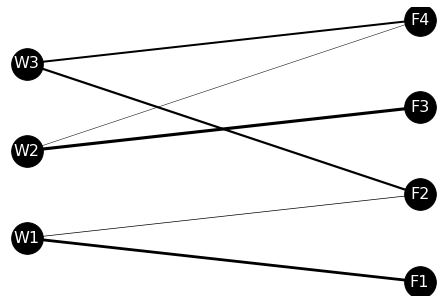

In [4]:
# 라이브러리 임포트
import matplotlib.pyplot as plt
import networkx as nx

# 운송 경로, 위치 정보 데이터
df_tr = df_tr_sol.copy() # 위에서 계산한 최적화 경로 데이터
df_pos = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/7장/trans_route_pos.csv')

# 객체 생성
G = nx.Graph()

# 노드 설정
for i in range(len(df_pos.columns)):
  G.add_node(df_pos.columns[i])

# 엣지 설정 및 엣지 가중치 리스트화
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
  for j in range(len(df_pos.columns)):
    if not (i == j):
      # 엣지 추가
      G.add_edge(df_pos.columns[i], df_pos.columns[j])
      # 엣지 가중치 추가
      if num_pre < len(G.edges):
        num_pre = len(G.edges)
        weight = 0
        if (df_pos.columns[i] in df_tr.columns) and (df_pos.columns[j] in df_tr.index):
          if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
            weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
        elif (df_pos.columns[j] in df_tr.columns) and (df_pos.columns[i] in df_tr.index):
          if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
            weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
        edge_weights.append(weight)

# 좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
  node = df_pos.columns[i]
  pos[node] = (df_pos[node][0], df_pos[node][1])

# 그리기
nx.draw(G, pos, with_labels = True, font_size = 16, node_size = 1000, node_color = 'k', font_color = 'w', width = edge_weights)

# 표시
plt.show()

- 창고 W1 → 공장 F1, 창고 W2 → 공장 F3, 창고 W3 → 공장 F2, F4로의 공급이 대부분
- 나머지 경로는 최소화 되어 있음

### 테크닉 063 : 최적 운송 경로가 제약 조건을 만족하는지 확인하자

- 테크닉 60에서 작성한 제약 조건을 계산하는 함수 이용, 계산된 운송 경로가 제약 조건을 만족하는지 확인

In [5]:
# 제약조건 계산함수
# 수요측
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag
            
# 공급측
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("수요 조건 계산 결과:"+str(condition_demand(df_tr_sol,df_demand)))
print("공급 조건 계산 결과:"+str(condition_supply(df_tr_sol,df_supply)))

수요 조건 계산 결과:[1. 1. 1. 1.]
공급 조건 계산 결과:[1. 1. 1.]


- 수요 조건과 공급 조건 모두 1로 만족
- 목적함수와 제약 조건만 명확하게 정의한다면 최적화 계산 도구를 이용하여 간단히 답을 구할 수 있음

### 테크닉 064 : 생산 계획 데이터를 불러오자

- 운송 비용 최적화를 해결했으니, 다음은 생산 계획을 다룰 차례

### 데이터
- product_plan_material.csv : 제품 제조에 필요한 원료 비율
- product_plan_profit.csv : 제품 이익
- product_plan_stock.csv : 원료 재고
- product_paln.csv : 제품 생산량

In [6]:
# 데이터 불러오기
df_material = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/7장/product_plan_material.csv', index_col = '제품')
print(df_material)

df_profit = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/7장/product_plan_profit.csv', index_col = '제품')
print(df_profit)

df_stock = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/7장/product_plan_stock.csv', index_col = '항목')
print(df_stock)

df_plan = pd.read_csv('/content/drive/My Drive/pyda100/pyda100-master/7장/product_plan.csv', index_col = '제품')
print(df_plan)

     원료1  원료2  원료3
제품                
제품1    1    4    3
제품2    2    4    1
      이익
제품      
제품1  5.0
제품2  4.0
    원료1  원료2  원료3
항목               
재고   40   80   50
      생산량
제품       
제품1    16
제품2     0


- 이익이 다소 적은 제품2는 생산 계획이 없음
- 따라서 원료 재고가 비효율적으로 발생
- 제품2의 생산량을 늘려 이익을 높일 방법을 찾는 것이 중요

### 테크닉 065 : 이익을 계산하는 함수를 만들자
- 생산계획 최적화는 최적화 문제의 일반적인 흐름과 동일
- 목적함수와 제약 조건 정의 후 목적함수를 최소화(혹은 최대화)하는 변수 조합을 찾음

In [7]:
# 이익 계산 함수
def product_plan(df_profit,df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
    return profit

print("총 이익:"+str(product_plan(df_profit,df_plan)))

총 이익:80.0


- 총 이익 : (각 제품의 이익 x 계획된 생산량)의 총 합
- 이 총 이익(80만원)은 제품 1만 계산된 것. 제품 2의 생산량을 늘려 변화 여부를 파악해보자

### 테크닉 066 : 생산 최적화 문제를 풀어보자
- 문제를 푸는 흐름은 테크닉 61과 동일

In [8]:
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals


df = df_material.copy()
inv = df_stock

m = model_max() # 최대화 계산
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))

# 각 원료 사용량이 원료 재고를 넘지 않도록 제약 조건 정의
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit)) ) <= df_stock.iloc[:,i]
m.solve()

df_plan_sol = df_plan.copy()
for k,x in v1.items():
    df_plan_sol.iloc[k] = value(x)
    
print(df_plan_sol)
print("총 이익:"+str(value(m.objective)))

      생산량
제품       
제품1  15.0
제품2   5.0
총 이익:95.0


- 제품1의 생산량이 16에서 15로 1 줄었고, 제품2의 생산량이 0에서 5로 늘었다
- 총 이익은 80에서 95로 증가

### 테크닉 067 : 최적 생산 계획이 제약 조건을 만족하는지 확인하자
- 최적화 문제를 풀 때 가장 주의할 점: 최적화 계산을 한 결과를 이해하지 않고 그냥 받아들이면 안된다는 것
- 제약 조건을 만족하는지 확인하는 것이 우선

In [9]:
# 제약 조건 계산 함수
def condition_stock(df_plan,df_material,df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):  
        temp_sum = 0
        for j in range(len(df_material.index)):  
            temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
        if (temp_sum<=float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i]+"  사용량:"+str(temp_sum)+", 재고:"+str(float(df_stock.iloc[0][i])))
    return flag

print("제약 조건 계산 결과:"+str(condition_stock(df_plan_sol,df_material,df_stock)))

원료1  사용량:25.0, 재고:40.0
원료2  사용량:80.0, 재고:80.0
원료3  사용량:50.0, 재고:50.0
제약 조건 계산 결과:[1. 1. 1.]


- 제약 조건 모두 충족
- 원료2, 원료3의 경우 재고를 모두 사용하고 원료1은 재고가 조금 남아 있음
- 비교적 효율적으로 원료 재고를 소비

### 테크닉 068 : 물류 네트워크 설계 문제를 풀어보자
- 이제 운송 경로와 생산 계획 최적화 문제를 함께 고려
- 상품의 수요가 이미 결정되어 있으면 이제 고려할 것은 어떻게 비용을 낮출 것인가 하는 것. 운송 비용과 제조 비용이 수요를 만족하면서 최소가 되게 정식화
- 목적함수 = 운송 비용 + 제조 비용
- 제약조건 = 대리점 판매 수 > 수요 수

In [10]:
import numpy as np
import pandas as pd

제품 = list('AB')
대리점 = list('PQ')
공장 = list('XY')
레인 = (2,2)

# 운송비 #
tbdi = pd.DataFrame(((j,k) for j in 대리점 for k in 공장), columns=['대리점','공장'])
tbdi['운송비'] = [1,2,3,1]
print(tbdi)

# 수요 #
tbde = pd.DataFrame(((j,i) for j in 대리점 for i in 제품), columns=['대리점','제품'])
tbde['수요'] = [10,10,20,20]
print(tbde)

# 생산 #
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (공장,레인) for l in range(nl) for i in 제품), 
                    columns=['공장','레인','제품','하한','상한'])
tbfa['생산비'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'상한']=10
print(tbfa)

from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa,dep = "대리점", dem = "수요",fac = "공장",
                                prd = "제품",tcs = "운송비",pcs = "생산비",lwb = "하한",upb = "상한")

print(tbfa)
print(tbdi2)

  대리점 공장  운송비
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  대리점 제품  수요
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  공장  레인 제품  하한    상한  생산비
0  X   0  A   0   inf  1.0
3  X   1  B   0   inf  1.0
4  Y   0  A   0  10.0  3.0
6  Y   1  A   0   inf  5.0
7  Y   1  B   0   inf  3.0
  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000009  20.0
3  X   1  B   0   inf  1.0  v000010  10.0
4  Y   0  A   0  10.0  3.0  v000011  10.0
6  Y   1  A   0   inf  5.0  v000012   0.0
7  Y   1  B   0   inf  3.0  v000013  20.0
  대리점 공장  운송비 제품     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


- 함수 logistics_network)
- ValY: 최적 생산량
- ValX: 최적 운송량

### 테크닉 069 : 최적 네트워크의 운송 비용과 그 내역을 계산하자
- 운송 비용: logistics_network의 반환값으로 tbdi2에 저장됨
- '운송비' 칼럼과 'ValX' 칼럼(최적 운송량)을 곱하면 운송 비용 계산 가능

In [11]:
# 칼럼 재정렬
tbdi2 = tbdi2[['공장', '대리점', '운송비', '제품', 'VarX', 'ValX']]
tbdi2

,공장,대리점,운송비,제품,VarX,ValX
0,X,P,1,A,v000001,10.0
1,X,P,1,B,v000002,10.0
2,X,Q,3,A,v000003,10.0
3,X,Q,3,B,v000004,0.0
4,Y,P,2,A,v000005,0.0
5,Y,P,2,B,v000006,0.0
6,Y,Q,1,A,v000007,10.0
7,Y,Q,1,B,v000008,20.0


In [12]:
trans_cost = 0
for i in range(len(tbdi2.index)):
  trans_cost += tbdi2['운송비'].iloc[i]*tbdi2['ValX'].iloc[i]
print('총 운송비:' + str(trans_cost))

총 운송비:80.0


### 테크닉 070 : 최적 네트워크의 생산 비용과 그 내역을 계산하자

In [13]:
# tbfa: 생산 비용
# 생산 비용 = '생산비' 칼럼 * ValY 칼럼(최적 생산량)
print(tbfa)
product_cost = 0
for i in range(len(tbfa.index)):
  product_cost += tbfa['생산비'].iloc[i]*tbfa['ValY'].iloc[i]
print('총 생산비:' + str(product_cost))

  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000009  20.0
3  X   1  B   0   inf  1.0  v000010  10.0
4  Y   0  A   0  10.0  3.0  v000011  10.0
6  Y   1  A   0   inf  5.0  v000012   0.0
7  Y   1  B   0   inf  3.0  v000013  20.0
총 생산비:120.0
